<a href="https://colab.research.google.com/github/Sudhir22/Plane-Accident-Severity/blob/master/Model_XGBoost%2BCat_Boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q xlrd
!git clone https://github.com/Sudhir22/Plane-Accident-Severity.git

Cloning into 'Plane-Accident-Severity'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [0]:
pip install catboost

     |████████████████████████████████| 64.0MB 67kB/s 


In [0]:
import pandas as pd
import xgboost as xbg
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier


In [0]:
train_data=pd.read_csv('Plane-Accident-Severity/train.csv')

In [0]:
train_data.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054


In [0]:
total_cases_accident_type=dict()
i=1
for index,row in train_data.groupby(['Accident_Type_Code']):
  total_cases_accident_type[i]=row.shape[0]
  i+=1


In [36]:
total_cases_accident_type

{1: 1171, 2: 1791, 3: 1752, 4: 2057, 5: 738, 6: 1215, 7: 1276}

In [0]:
accident_type_code_mean=dict()
for index,row in train_data.groupby(['Accident_Type_Code','Severity_Code']):
  accident_type_code_mean[index]=row.shape[0]/total_cases_accident_type[index[0]]

In [39]:
accident_type_code_mean

{(1, 0): 0.4449188727583262,
 (1, 1): 0.19726729291204098,
 (1, 2): 0.2228864218616567,
 (1, 3): 0.1349274124679761,
 (2, 0): 0.2573981016192071,
 (2, 1): 0.570072585147962,
 (2, 2): 0.09380234505862646,
 (2, 3): 0.07872696817420435,
 (3, 0): 0.1797945205479452,
 (3, 1): 0.17636986301369864,
 (3, 2): 0.05422374429223744,
 (3, 3): 0.5896118721461188,
 (4, 0): 0.5726786582401555,
 (4, 1): 0.13077297034516286,
 (4, 2): 0.19397180359747204,
 (4, 3): 0.10257656781720953,
 (5, 0): 0.22764227642276422,
 (5, 1): 0.4742547425474255,
 (5, 2): 0.10840108401084012,
 (5, 3): 0.1897018970189702,
 (6, 0): 0.1728395061728395,
 (6, 1): 0.1588477366255144,
 (6, 2): 0.07654320987654321,
 (6, 3): 0.5917695473251029,
 (7, 0): 0.1536050156739812,
 (7, 1): 0.1206896551724138,
 (7, 2): 0.46943573667711597,
 (7, 3): 0.256269592476489}

In [0]:
accident_type_code_mean_values=list()
for index,row in train_data.iterrows():
  accident_type_code_mean_values.append(accident_type_code_mean[(row['Accident_Type_Code'],row['Severity_Code'])])


In [0]:
train_data['Accident_Type_Code_Mean']=pd.Series(accident_type_code_mean_values)

In [0]:
train_data.groupby(['Severity']).count()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
Severity,,,,,,,,,,,
Highly_Fatal_And_Damaging,3049,3049,3049,3049,3049,3049,3049,3049,3049,3049,3049
Minor_Damage_And_Injuries,2527,2527,2527,2527,2527,2527,2527,2527,2527,2527,2527
Significant_Damage_And_Fatalities,1695,1695,1695,1695,1695,1695,1695,1695,1695,1695,1695
Significant_Damage_And_Serious_Injuries,2729,2729,2729,2729,2729,2729,2729,2729,2729,2729,2729


In [0]:
train_data['Severity']=pd.Categorical(train_data['Severity'])
train_data['Severity_Code']=train_data['Severity'].cat.codes

In [0]:
data_corr=train_data.corr()

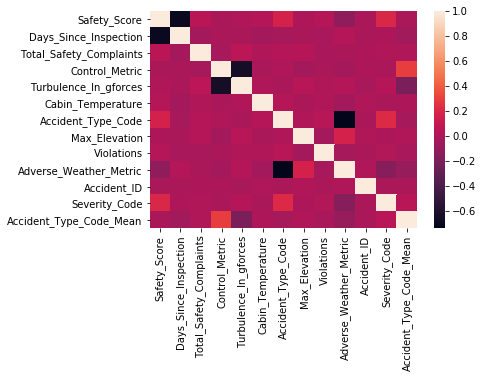

In [43]:
sns.heatmap(data_corr)

In [44]:
train_data.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID,Severity_Code,Accident_Type_Code_Mean
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570,1,0.570073
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128,1,0.570073
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181,2,0.469436
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946,3,0.589612
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054,2,0.054224


In [46]:
X=train_data.iloc[:,[1,2,3,4,5,6,7,8,9,10,13]]
X.head()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_Type_Code_Mean
0,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,0.570073
1,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,0.570073
2,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,0.469436
3,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,0.589612
4,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,0.054224


In [0]:
Y=train_data.iloc[:,12]

In [0]:
kf=KFold(n_splits=5)

In [0]:
param = {
    'eta': 0.2, 
    'max_depth': 12,  
    'objective': 'multi:softprob',  
    'gamma': 0.01,
    'num_class': 4} 

steps = 1000  # The number of training iterations

In [50]:
for x,y in kf.split(X):
  print(x,y)
  X_train,X_test = X.iloc[x,:],X.iloc[y,:]
  Y_train,Y_test = Y[x],Y[y]
  D_train = xbg.DMatrix(X_train, label=Y_train)
  D_test = xbg.DMatrix(X_test, label=Y_test)
  model = xbg.train(param, D_train, steps)
  preds = model.predict(D_test)
  best_preds = np.asarray([np.argmax(line) for line in preds])


  print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
  print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
  print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))
  print("F1-score = {}".format(f1_score(Y_test,best_preds,average='weighted')))
  print("********************************************************************")

  '''model1=MLPClassifier(hidden_layer_sizes=(100,100,100),max_iter=1000,alpha=0.01,activation='relu')
  model1.fit(X_train,Y_train)
  best_preds_nn=model1.predict(X_test)
  print("F1-score = {}".format(f1_score(Y_test,best_preds_nn,average='weighted')))'''

  '''model2=SVC(C=1,kernel='poly', degree=4,gamma='auto')
  model2.fit(X_train,Y_train)
  best_preds_svm = model2.predict(X_test)
  print(best_preds_svm.tolist().count(0))
  print(best_preds_svm.tolist().count(1))
  print(best_preds_svm.tolist().count(2))
  print(best_preds_svm.tolist().count(3))
  print("F1-score = {}".format(f1_score(Y_test,best_preds_svm,average='weighted')))'''

  model3=CatBoostClassifier(iterations=1000,learning_rate=0.01,depth=12,loss_function='MultiClass',verbose=False)
  model3.fit(X_train,Y_train)
  best_preds_cat=model3.predict(X_test)
  preds_cat=model3.predict_proba(X_test)
  print("F1-score = {}".format(f1_score(Y_test,best_preds_cat,average='weighted')))


  average_preds=(np.array(preds)+np.array(preds_cat))/2.0
  best_preds_average = np.asarray([np.argmax(line) for line in average_preds])
  print("F1-score = {}".format(f1_score(Y_test,best_preds_average,average='weighted')))

  


[2000 2001 2002 ... 9997 9998 9999] [   0    1    2 ... 1997 1998 1999]


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Precision = 1.0
Recall = 1.0
Accuracy = 1.0
F1-score = 1.0
********************************************************************
F1-score = 1.0
F1-score = 1.0
[   0    1    2 ... 9997 9998 9999] [2000 2001 2002 ... 3997 3998 3999]
Precision = 1.0
Recall = 1.0
Accuracy = 1.0
F1-score = 1.0
********************************************************************
F1-score = 1.0
F1-score = 1.0
[   0    1    2 ... 9997 9998 9999] [4000 4001 4002 ... 5997 5998 5999]
Precision = 1.0
Recall = 1.0
Accuracy = 1.0
F1-score = 1.0
********************************************************************
F1-score = 1.0
F1-score = 1.0
[   0    1    2 ... 9997 9998 9999] [6000 6001 6002 ... 7997 7998 7999]
Precision = 1.0
Recall = 1.0
Accuracy = 1.0
F1-score = 1.0
********************************************************************
F1-score = 1.0
F1-score = 1.0
[   0    1    2 ... 7997 7998 7999] [8000 8001 8002 ... 9997 9998 9999]
Precision = 1.0
Recall = 1.0
Accuracy = 1.0
F1-score = 1.0
*********************

In [0]:
test_data=pd.read_csv("Plane-Accident-Severity/test.csv")

In [0]:
test_data.shape

(2500, 12)

In [0]:
test_X=test_data.iloc[:,0:10]

In [0]:
test_X.head()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric
0,19.497717,16,6,72.151322,0.388959,78.32,4,37949.724386,2,0.069692
1,58.173516,15,3,64.585232,0.250841,78.60,7,30194.805567,2,0.002777
2,33.287671,15,3,64.721969,0.336669,86.96,6,17572.925484,1,0.004316
3,3.287671,21,5,66.362808,0.421775,80.86,3,40209.186341,2,0.199990
4,10.867580,18,2,56.107566,0.313228,79.22,2,35495.525408,2,0.483696


In [0]:
test_X.shape

(2500, 10)

In [0]:
D_test_test=xbg.DMatrix(test_X)
test_preds = model.predict(D_test_test)
best_test_preds = np.asarray([np.argmax(line) for line in test_preds])

In [0]:
test_preds.shape

(2500, 4)

In [0]:
severity_dict={1:'Minor_Damage_And_Injuries',2:'Significant_Damage_And_Fatalities',3:'Significant_Damage_And_Serious_Injuries',0:'Highly_Fatal_And_Damaging'}

In [0]:
severity_list=list()
for x in best_test_preds:
  severity_list.append(severity_dict[x])

In [0]:
test_data['Severity']=pd.Series(severity_list)

In [0]:
test_data[['Accident_ID','Severity']].to_csv("Plane-Accident-Severity/submission5.csv",index=False)